In [ ]:
# 2. Mount Google Drive to access your data
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


       Timestamp    RPM  Setpoint  Error  PrevPWM     PWM  PWMPrev
1             46    0.0      50.0     50     1899  1989.0   1899.0
2             48    0.0      50.0     50     1989  2038.0   1989.0
3             50    0.0      50.0     50     2038  2062.0   2038.0
4             52    0.0      50.0     50     2062  2074.0   2062.0
5             54    0.0      50.0     50     2074  2080.0   2074.0
...          ...    ...       ...    ...      ...     ...      ...
23641      47326  600.0     600.0      0     7699  7700.0   7699.0
23642      47328  599.0     600.0      1     7700  7700.0   7700.0
23643      47330  599.0     600.0      1     7700  7701.0   7700.0
23644      47332  599.0     600.0      1     7701  7702.0   7701.0
23645      47334  599.0     600.0      1     7702  7702.0   7702.0

[23645 rows x 7 columns]


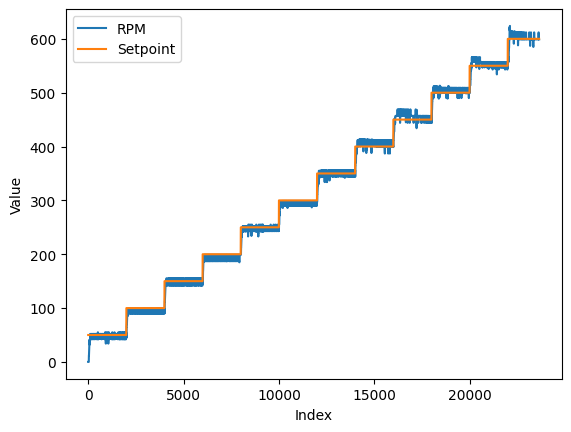

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df_first = pd.read_csv(r'/content/drive/MyDrive/motor dataset/teio_step.csv')
df_first['PWMPrev'] = df_first['PWM'].shift(1)
df_first = df_first.dropna()
df_first.rename(columns={'Timestamp (ms)': 'Timestamp'}, inplace=True)
print (df_first)

first_rpm = df_first['RPM']
first_offset = df_first['Setpoint']

plt.figure()
plt.plot(first_rpm, label="RPM")
plt.plot(first_offset, label="Setpoint")

plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()     # <-- shows separate labels for each line
plt.show()




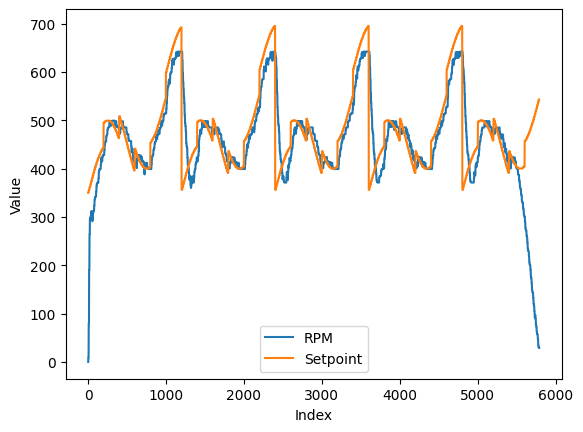

In [ ]:
second_csv_file = r'/content/drive/MyDrive/motor dataset/sine_changing_offset_high.csv'
df_second = pd.read_csv(second_csv_file)
df_second['PWMPrev'] = df_second['PWM'].shift(1)
df_second = df_second.dropna()
second_rpm = df_second['RPM']
second_offset = df_second['Setpoint']

plt.figure()
plt.plot(second_rpm, label="RPM")
plt.plot(second_offset, label="Setpoint")

plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()     # <-- shows separate labels for each line
plt.show()


In [ ]:
fourth_csv_file = r'/content/drive/MyDrive/motor dataset/teio_step.csv'
df_fourth = pd.read_csv(fourth_csv_file)
df_fourth['PWMPrev'] = df_fourth['PWM'].shift(1)
df_fourth = df_fourth.dropna()
fourth_rpm = df_fourth['RPM']
fourth_offset = df_fourth['Setpoint']

plt.figure()
plt.plot(fourth_rpm, label="RPM")
plt.plot(fourth_offset, label="Setpoint")

plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

NameError: name 'pd' is not defined

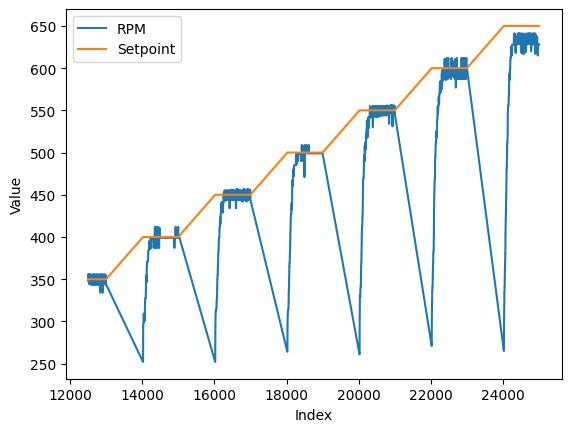

In [ ]:
sixth_csv_file = r'/content/drive/MyDrive/motor dataset/step_up_and_down_new_pi.csv'
df_sixth = pd.read_csv(sixth_csv_file)

df_sixth['PWMPrev'] = df_sixth['PWM'].shift(1)
df_sixth = df_sixth.dropna()
df_sixth = df_sixth[12500:]

# DELETE rows with negative RPM
df_sixth = df_sixth[
    (df_sixth['RPM'] >= 250) &
    (df_sixth['Setpoint'] >= 250)
]


sixth_rpm = df_sixth['RPM']
sixth_offset = df_sixth['Setpoint']

plt.figure()
plt.plot(sixth_rpm, label="RPM")
plt.plot(sixth_offset, label="Setpoint")

plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()


       Timestamp    RPM  Setpoint  Error  PrevPWM     PWM  PWMPrev
0           46.0    0.0      50.0     50     1899  1989.0   1899.0
1           48.0    0.0      50.0     50     1989  2038.0   1989.0
2           50.0    0.0      50.0     50     2038  2062.0   2038.0
3           52.0    0.0      50.0     50     2062  2074.0   2062.0
4           54.0    0.0      50.0     50     2074  2080.0   2074.0
...          ...    ...       ...    ...      ...     ...      ...
30023    50029.0  628.0     650.0     22     8153  8161.0   8153.0
30024    50031.0  628.0     650.0     22     8161  8170.0   8161.0
30025    50033.0  628.0     650.0     22     8170  8179.0   8170.0
30026    50035.0  628.0     650.0     22     8179  8187.0   8179.0
30027    50037.0  628.0     650.0     22     8187  8191.0   8187.0

[30028 rows x 7 columns]


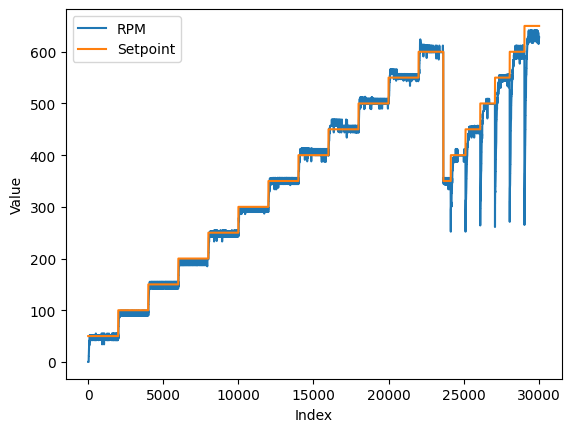

In [ ]:
df_final = pd.concat([df_first, df_sixth], axis=0, ignore_index=True)

print (df_final)
final_rpm = df_final['RPM']
final_offset = df_final['Setpoint']

plt.figure()
plt.plot(final_rpm, label="RPM")
plt.plot(final_offset, label="Setpoint")

plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
# --- CELL 1: Data Consolidation and Setup ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split # Still import, but we won't use it now
import matplotlib.pyplot as plt

# 1. Define Fixed Scaling Limits (CRUCIAL for ESP32 Deployment)
PWM_MIN, PWM_MAX = 0.0, 8192.0
RPM_MIN, RPM_MAX = 0.0, 635.0
PWM_RANGE = PWM_MAX - PWM_MIN
RPM_RANGE = RPM_MAX - RPM_MIN

# 2. Define File Paths and Load DataFrames
# !!! VERIFY THESE PATHS MATCH YOUR DRIVE STRUCTURE !!!
'''path_sine_rhythmic = '/content/drive/MyDrive/motor dataset/sine_changing_offset.csv'
path_step_down = '/content/drive/MyDrive/motor dataset/step_down.csv' # Assuming you named it this'''

'''df_sine = pd.read_csv(path_sine_rhythmic)
df_step_down = pd.read_csv(path_step_down)'''


# 3. Standardize Column Names Across All DataFrames
# The name of the timestamp column varies, so we standardize the others first.
rename_map = {
    'RPM': 'omega_act',
    'Setpoint': 'omega_des',
    'PWMPrev': 'u_total_last_raw',
    'PWM': 'u_total'
}

'''df_sine.rename(columns=rename_map, inplace=True)
df_step_down.rename(columns=rename_map, inplace=True)'''

df_final.rename(columns=rename_map, inplace=True)

# 4. CONSOLIDATE DATA: Create the Final Training Set
'''df_train_final = pd.concat([df_sine, df_step_down], ignore_index=True)'''
df_train_final = df_final

# 5. Define the Input Features and Target
INPUT_FEATURES = ['omega_des', 'omega_act', 'u_total_last_raw']
TARGET_FEATURE = 'u_total'

# Load final data arrays
X_data = df_train_final[INPUT_FEATURES].values.astype(np.float32)
Y_data = df_train_final[TARGET_FEATURE].values.reshape(-1, 1).astype(np.float32)

# DEBUG CHECK: Check for NaNs and Infs after consolidation
print(f"Total Consolidated Samples: {X_data.shape[0]}")
print(f"NaN count after consolidation: \n{df_train_final.isnull().sum()}")
df_train_final.dropna(inplace=True)

# Re-run X/Y assignment after dropping NaNs, if any were found
X_data = df_train_final[INPUT_FEATURES].values.astype(np.float32)
Y_data = df_train_final[TARGET_FEATURE].values.reshape(-1, 1).astype(np.float32)
print(f"Final Samples for Training: {X_data.shape[0]}")

Total Consolidated Samples: 30028
NaN count after consolidation: 
Timestamp           0
omega_act           0
omega_des           0
Error               0
PrevPWM             0
u_total             0
u_total_last_raw    0
dtype: int64
Final Samples for Training: 30028


In [ ]:
# --- CELL 2: Data Preprocessing (Normalization Only) ---

# Custom Normalization Function
def normalize_data(data, data_min, data_range):
    """ Scales data to the range [0, 1] using fixed physical limits. """
    return (data - data_min) / data_range

# 1. Prepare Input (X) Data - Scales inputs according to their type (RPM or PWM)
X_data_scaled = np.zeros_like(X_data, dtype=np.float32)

# Input 1: Desired RPM (Index 0 - omega_des) -> Scale by RPM_RANGE
X_data_scaled[:, 0] = normalize_data(X_data[:, 0], RPM_MIN, RPM_RANGE)

# Input 2: Actual RPM (Index 1 - omega_act) -> Scale by RPM_RANGE
X_data_scaled[:, 1] = normalize_data(X_data[:, 1], RPM_MIN, RPM_RANGE)

# Input 3: Last Total PWM (Index 2 - u_total_last_raw) -> Scale by PWM_RANGE
X_data_scaled[:, 2] = normalize_data(X_data[:, 2], PWM_MIN, PWM_RANGE)


# 2. Prepare Target (Y) Data - Scales the current total PWM output
Y_data_scaled = normalize_data(Y_data.flatten(), PWM_MIN, PWM_RANGE).reshape(-1, 1)


# 3. Assign All Data to Training (Validation will be external)
X_train = X_data_scaled
Y_train = Y_data_scaled

print(f"All {X_train.shape[0]} samples assigned to Training Set.")

All 30028 samples assigned to Training Set.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

print("Eager:", tf.executing_eagerly())

model = load_model(
    '/content/drive/MyDrive/motor dataset/motor_nn_controller_final.h5',
    compile=False
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)

history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=32,
    verbose=1
)


Eager: True
Epoch 1/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.3115e-05 - mean_absolute_error: 0.0033
Epoch 2/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6624e-05 - mean_absolute_error: 0.0026
Epoch 3/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7969e-05 - mean_absolute_error: 0.0028
Epoch 4/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6085e-05 - mean_absolute_error: 0.0026
Epoch 5/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2288e-05 - mean_absolute_error: 0.0025
Epoch 6/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2723e-05 - mean_absolute_error: 0.0024
Epoch 7/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6099e-05 - mean_absolute_error: 0.0026
Epoch 8/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9552e-05 - mean_absolute_error: 0.0026
Epoch 9/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1571e-05 - mean_absolute_error: 0.0025
Epoch 10/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6179e-05 - mean_

In [ ]:
# --- CELL 5: Validation on STEP UP Data ---

# 1. Define the path to your Step Up Test Data
# !!! CHANGE THIS PATH !!!
step_up_data_path = '/content/drive/MyDrive/motor dataset/step.csv'
df_val_step = pd.read_csv(step_up_data_path)

# 2. Standardize Column Names (Assuming you successfully cleaned the CSV)
df_val_step.rename(columns={
    'Timestamp': 'timestamp',
    'RPM': 'omega_act',
    'Setpoint': 'omega_des',
    'PWMPrev': 'u_total_last_raw',
    'PWM': 'u_total_target'
}, inplace=True)

# 3. Define test input data (must be float32)
X_step_raw = df_val_step[['omega_des', 'omega_act', 'u_total_last_raw']].values.astype(np.float32)
Y_step_raw_target = df_val_step['u_total_target'].values.reshape(-1, 1).astype(np.float32)

# 4. Normalize the Step Test Data
X_step_scaled = np.zeros_like(X_step_raw, dtype=np.float32)

# Scale RPM inputs
X_step_scaled[:, 0] = normalize_data(X_step_raw[:, 0], RPM_MIN, RPM_RANGE)
X_step_scaled[:, 1] = normalize_data(X_step_raw[:, 1], RPM_MIN, RPM_RANGE)
X_step_scaled[:, 2] = normalize_data(X_step_raw[:, 2], PWM_MIN, PWM_RANGE)

Y_step_scaled_target = normalize_data(Y_step_raw_target.flatten(), PWM_MIN, PWM_RANGE).reshape(-1, 1)


# 5. Predict PWM using the Trained Model and De-Normalize
Y_step_scaled_predicted = model.predict(X_step_scaled, verbose=0)
Y_step_raw_predicted = unscale_data(Y_step_scaled_predicted, PWM_MIN, PWM_RANGE)


# 6. Evaluate Performance
loss, mae = model.evaluate(X_step_scaled, Y_step_scaled_target, verbose=0)
raw_pwm_mae = mae * PWM_RANGE

print("\n--- Validation Check 2: Step Up Data (Sharp Acceleration) ---")
print(f"Test MAE (Normalized): {mae:.6f}")
print(f"Test MAE (Raw PWM Units): {raw_pwm_mae:.2f}")


# 7. Visualize the Tracking Performance (PWM)
plt.figure(figsize=(12, 6))
plt.plot(df_val_step['timestamp'], Y_step_raw_target, label='Actual PWM Used (Target)', alpha=0.7, linewidth=2)
plt.plot(df_val_step['timestamp'], Y_step_raw_predicted, label='FNN Predicted PWM', linestyle='--', alpha=1.0, linewidth=2)

plt.title('FNN Prediction vs. Actual PWM (Step Up Data)')
plt.xlabel('Time (ms)')
plt.ylabel('PWM Command (0 - 8192)')
plt.legend()
plt.grid(True)
plt.show()

KeyError: "['u_total_last_raw'] not in index"


--- Data Quality Check: Unseen Sine Wave ---
NaN count before cleaning: 
timestamp           1
omega_act           1
omega_des           1
Error               0
u_total_last_raw    0
u_total_target      1
dtype: int64
Total Samples after cleaning: 11418
--- End of Check ---

--- Validation Check 1: Unseen Sine Wave (Continuous Tracking) ---
Test MAE (Normalized): 0.006206
Test MAE (Raw PWM Units): 50.84


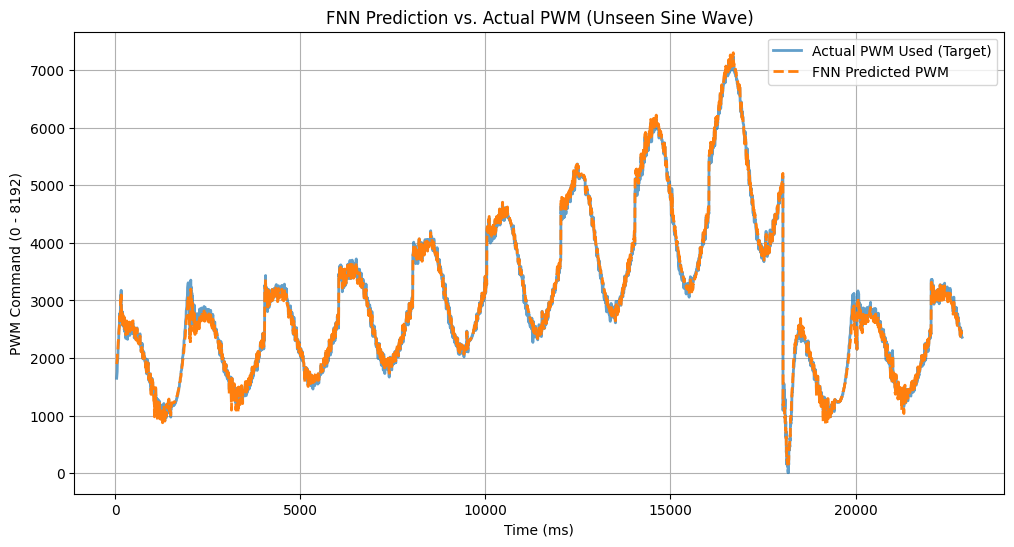

In [ ]:
# --- CELL 4: Validation on UNSEEN Sine Wave Data (DIAGNOSTIC CHECK) ---

# 1. Define the path to your new Sine Wave Validation Data
sine_val_data_path = '/content/drive/MyDrive/motor dataset/sine_changing_offset_periodic.csv'
df_val_sine = pd.read_csv(sine_val_data_path)

# 2. Standardize Column Names
# Assuming you successfully cleaned the column names in the CSV file manually:
df_val_sine.rename(columns={
    'Timestamp': 'timestamp',
    'RPM': 'omega_act',
    'Setpoint': 'omega_des',
    'PWMPrev': 'u_total_last_raw',
    'PWM': 'u_total_target'
}, inplace=True)

# 3. CRITICAL DEBUGGING CHECKS
print("\n--- Data Quality Check: Unseen Sine Wave ---")
# Check for explicit NaNs
print(f"NaN count before cleaning: \n{df_val_sine.isnull().sum()}")
if df_val_sine.isnull().values.any():
    print("WARNING: NaNs found. Dropping rows with any NaN values.")
    df_val_sine.dropna(inplace=True)

# Define test input data (must be float32)
X_sine_raw = df_val_sine[['omega_des', 'omega_act', 'u_total_last_raw']].values.astype(np.float32)
Y_sine_raw_target = df_val_sine['u_total_target'].values.reshape(-1, 1).astype(np.float32)

# Check for Infinite Values (Infs)
if np.isinf(X_sine_raw).any():
    print("CRITICAL ERROR: Infinite values detected in raw X data!")
    # Filter out or replace Infs if possible
    X_sine_raw[np.isinf(X_sine_raw)] = np.nan
    df_val_sine = df_val_sine[~np.isinf(X_sine_raw).any(axis=1)]

# Final check before normalization
print(f"Total Samples after cleaning: {X_sine_raw.shape[0]}")
print("--- End of Check ---")


# 4. Normalize the Sine Test Data using the fixed global limits (RPM_MIN/MAX, PWM_MIN/MAX)
X_sine_scaled = np.zeros_like(X_sine_raw, dtype=np.float32)

# Scale RPM inputs
X_sine_scaled[:, 0] = normalize_data(X_sine_raw[:, 0], RPM_MIN, RPM_RANGE)
X_sine_scaled[:, 1] = normalize_data(X_sine_raw[:, 1], RPM_MIN, RPM_RANGE)

# Scale PWM input
X_sine_scaled[:, 2] = normalize_data(X_sine_raw[:, 2], PWM_MIN, PWM_RANGE)

Y_sine_scaled_target = normalize_data(Y_sine_raw_target.flatten(), PWM_MIN, PWM_RANGE).reshape(-1, 1)


# 5. Predict PWM using the Trained Model and De-Normalize
# The verbose=0 hides the progress bar, preventing potential issues during debug
Y_sine_scaled_predicted = model.predict(X_sine_scaled, verbose=0)


# 6. Evaluate Performance (If prediction was NaN, evaluation will also be NaN)
loss, mae = model.evaluate(X_sine_scaled, Y_sine_scaled_target, verbose=0)
raw_pwm_mae = mae * PWM_RANGE

print("\n--- Validation Check 1: Unseen Sine Wave (Continuous Tracking) ---")
print(f"Test MAE (Normalized): {mae:.6f}")
print(f"Test MAE (Raw PWM Units): {raw_pwm_mae:.2f}")


# 7. Visualize (Only if MAE is not NaN)
if not np.isnan(mae):
    Y_sine_raw_predicted = unscale_data(Y_sine_scaled_predicted, PWM_MIN, PWM_RANGE)

    plt.figure(figsize=(12, 6))
    plt.plot(df_val_sine['timestamp'], Y_sine_raw_target, label='Actual PWM Used (Target)', alpha=0.7, linewidth=2)
    plt.plot(df_val_sine['timestamp'], Y_sine_raw_predicted, label='FNN Predicted PWM', linestyle='--', alpha=1.0, linewidth=2)
    plt.title('FNN Prediction vs. Actual PWM (Unseen Sine Wave)')
    plt.xlabel('Time (ms)')
    plt.ylabel('PWM Command (0 - 8192)')
    plt.legend()
    plt.grid(True)
    plt.show()

# If the error is not resolved, the problem may be that one of the RPM or PWM values
# in the CSV is outside the fixed limits (RPM_MAX=635, PWM_MAX=8192).
# This would cause the normalization to create values far outside the [0, 1] range,
# leading to the NaN error.

In [ ]:
# --- STEP 1: Ensure Model is Saved to the Correct Location ---
# This assumes you have already run Cell 3 and the 'model' object is in memory!

import os
from tensorflow import keras

# Define the BASE FOLDER where the model should be saved
base_folder = '/content/drive/MyDrive/motor dataset/'
model_file_name = 'motor_nn_controller_final_10_epochs_17_12_copy.h5'
model_save_path = os.path.join(base_folder, model_file_name)

# Ensure the folder exists (it should, being your Drive folder)
if not os.path.exists(base_folder):
    os.makedirs(base_folder)

# --- SAVE THE MODEL HERE ---
# This creates the .h5 file that the next block needs.
model.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")
print("Ready to proceed to Step 2: Extracting Weights.")

Model saved successfully to: /content/drive/MyDrive/motor dataset/motor_nn_controller_final_10_epochs_17_12_copy.h5
Ready to proceed to Step 2: Extracting Weights.


In [ ]:
# --- CELL 6: Keras Model to C++ Header File Generator (FINAL RUN - CUSTOM OBJECTS FIX) ---
import numpy as np
import os
from tensorflow import keras

# Import the necessary standard loss and metric functions
import keras.losses
import keras.metrics

# 1. Define the BASE FOLDER and FILE PATH
base_folder = '/content/drive/MyDrive/motor dataset/'
model_file_name = 'motor_nn_controller_final_10_epochs_17_12_copy.h5'
model_save_path = os.path.join(base_folder, model_file_name)

# Load the Saved Model using custom_objects to prevent the TypeError
# We explicitly tell Keras where to find 'mse' and 'mae'
model = keras.models.load_model(
    model_save_path,
    compile = False,
    custom_objects={
        'mse': keras.losses.mean_squared_error,
        'mae': keras.metrics.mean_absolute_error,
    }
)

# 2. Define File Paths for C++ Output
output_file_name = 'motor_nn_weights_10_epochs_17_12_copy.h'
output_header_path = os.path.join(base_folder, output_file_name)
header_file = open(output_header_path, 'w')

# 3. Write C++ Header Guard and Includes
header_file.write('#ifndef MOTOR_NN_WEIGHTS_H\n')
header_file.write('#define MOTOR_NN_WEIGHTS_H\n\n')
header_file.write('#include <math.h>\n\n')
header_file.write('// FNN Architecture: 3 inputs -> 20 nodes -> 20 nodes -> 1 output\n')
header_file.write('// Total Parameters: 521\n\n')

# 4. Extract and Format Weights/Biases (The extraction logic is unchanged)
layer_index = 0
for layer in model.layers:
    if isinstance(layer, keras.layers.Dense):
        layer_index += 1
        weights, biases = layer.get_weights()

        # --- A. Weights Array ---
        weights_shape = weights.shape
        var_name = f'w{layer_index}_weights'

        header_file.write(f'// Weights for Layer {layer_index}: Shape {weights_shape}\n')
        header_file.write(f'const float {var_name}[{weights_shape[0]}][{weights_shape[1]}] = {{\n')

        for i in range(weights_shape[0]):
            header_file.write('  {')
            values = [f'{w:.6f}f' for w in weights[i]]
            header_file.write(', '.join(values))
            header_file.write('}')
            if i < weights_shape[0] - 1:
                header_file.write(',\n')
            else:
                header_file.write('\n')
        header_file.write('};\n\n')

        # --- B. Biases Array ---
        biases_shape = biases.shape
        var_name = f'b{layer_index}_biases'

        header_file.write(f'// Biases for Layer {layer_index}: Shape {biases_shape}\n')
        header_file.write(f'const float {var_name}[{biases_shape[0]}] = {{\n')

        values = [f'{b:.6f}f' for b in biases]
        header_file.write('  ' + ', '.join(values) + '\n')
        header_file.write('};\n\n')

# 5. Write Closing Guard
header_file.write('#endif // MOTOR_NN_WEIGHTS_H\n')
header_file.close()

print(f"Successfully loaded model from: {model_save_path}")
print(f"Successfully exported {layer_index} layers to: {output_header_path}")
print("Your C++ weights header file is ready!")

Successfully loaded model from: /content/drive/MyDrive/motor dataset/motor_nn_controller_final_10_epochs_17_12_copy.h5
Successfully exported 3 layers to: /content/drive/MyDrive/motor dataset/motor_nn_weights_10_epochs_17_12_copy.h
Your C++ weights header file is ready!
